# Compare the 1cycle policy in fastai v0.7 and fastai v1.0

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The fastai library plots the learning rates and momentums after training. In here, we only want to see what learning rates will be used in the scheduler, so I mocked up the dataset, the learner and the fit function, for easier testing:

In [2]:
from mocks import *

In [3]:
data_size = 100
lr_max = 0.1
cycle_len = 2  # number of epochs

## 1. The 1cycle policy in fastai v0.7

I have created a symbolic link for fastai v0.7 in the `fastai_v0_7` folder, you can do it in your own way as long as you can import the required classes.  

In [4]:
from fastai_v0_7.sgdr import CircularLR_beta

clr = CircularLR_beta(LayerOptimizerMock(lr_max), data_size*cycle_len, 
                     div=25, pct=30, momentums=(0.95,0.85))

Now we simulate the fit function: 

In [5]:
simulate_fit_v0_7(data_size, cycle_len, [clr])

Epoch: 100%|██████████| 2/2 [00:00<00:00, 831.63it/s]


The we can plot the learning rates:

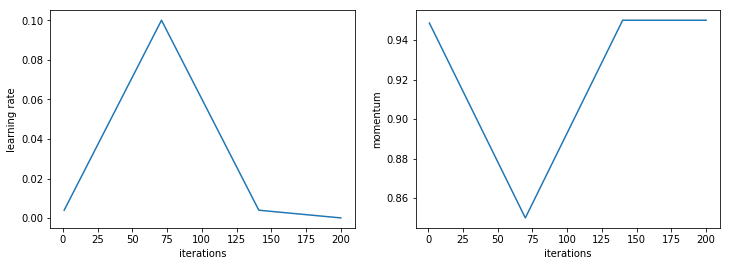

In [6]:
clr.plot_lr()

In [15]:
clr.lrs.index(0.1), clr.lrs[1:].index(cb.lrs[0])

(70, 139)

In [16]:
clr.cycle_nb

70

We can see by set `pct=30`, phase 1 and phase 2 got 35%, phase 3 got 30%, of the total iterations (2 epochs, 100 samples per epoch). 

## 2. The 1cycle policy in fastai v1

I have created a symbolic link for fastai v1.0 in the fastai_v1 folder, you can do it in your own way as long as you can import the required classes.

In [4]:
from fastai_v1.callbacks.one_cycle import OneCycleScheduler
from fastai_v1.basic_train import Recorder

learner = LearnerMock(data_size)
ocs = OneCycleScheduler(learner, lr_max,
                       moms=(0.95,0.85), div_factor=25., pct_start=0.3)
rc = Recorder(learner)

In [5]:
simulate_fit_v1(learner, cycle_len, [ocs, rc])

Epoch: 100%|██████████| 2/2 [00:00<00:00, 1435.91it/s]


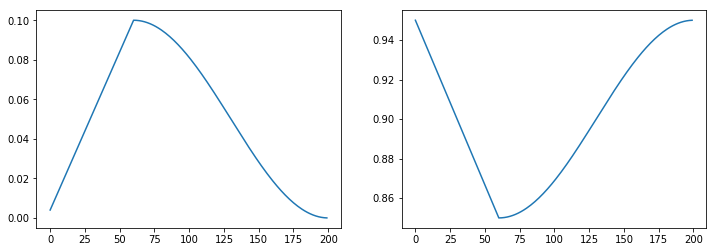

In [6]:
learner.recorder.plot_lr(True)

In [8]:
learner.recorder.lrs.index(0.1), ocs.pct_start*data_size*cycle_len

(60, 60.0)

We can see by setting `pct_start=0.3`, phase 1 got 30% and phase 2 got 60% of total iterations. 

## 3. The fastai v0.7 implementation of the fastai v1.0 1cycle policy

Now we use our own two-phase 1cycle policy in fastai v0.7: 

In [7]:
from one_cycle import OneCycleLR

clr1 = OneCycleLR(LayerOptimizerMock(lr_max), data_size*cycle_len)

In [8]:
simulate_fit_v0_7(data_size, cycle_len, [clr1])

Epoch: 100%|██████████| 2/2 [00:00<00:00, 604.58it/s]


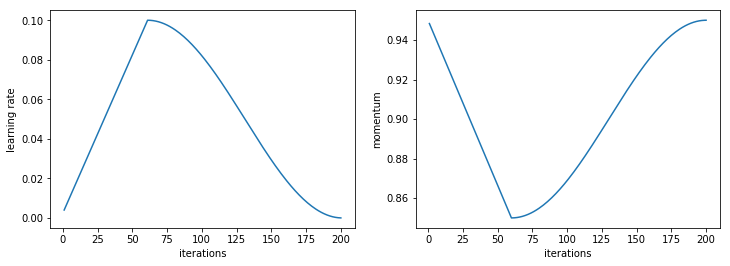

In [9]:
clr1.plot_lr()

We can see the plots are exactly the same. Now we compare all the numbers: 

In [11]:
sum([clr1.lrs[i] - learner.recorder.lrs[i] for i in range(len(clr1.lrs))])

0.0

In [13]:
sum([clr1.momentums[i] - learner.recorder.moms[i] for i in range(len(clr1.momentums))])

0.0

It matches exactly. 